# Unit 5 - Financial Planning

In [31]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [32]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [18]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [19]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [20]:
# Fetch current BTC price
btc_request = requests.get(btc_url)

# Fetch current ETH price
eth_request = requests.get(eth_url)

# Compute current value of my crpto

## For BTC
btc_data = btc_request.json()
btc_current_price = btc_data['data']['1']['quotes']['USD']['price']
my_btc_value = my_btc * btc_current_price

## For ETH
eth_data = eth_request.json()
eth_current_price = eth_data['data']['1027']['quotes']['USD']['price']
my_eth_value = my_eth * eth_current_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")


The current value of your 1.2 BTC is $22977.04
The current value of your 5.3 ETH is $6807.27


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [21]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [22]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='V2'
)

In [23]:
# Format current date as ISO format
today = pd.Timestamp('2022-10-07', tz='America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
my_investments_df = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = my_investments_df[my_investments_df['symbol']=='AGG'].drop('symbol', axis=1)
SPY = my_investments_df[my_investments_df['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
concatenated_df =  pd.concat([AGG, SPY], axis=1, keys=['AGG', 'SPY'])

# Preview DataFrame
concatenated_df.head()

AGG                                            \
                            open   high    low  close   volume trade_count   
timestamp                                                                    
2022-10-07 04:00:00+00:00  95.81  96.01  95.68  95.77  6149309       18717   

                                         SPY                            \
                                vwap    open      high     low   close   
timestamp                                                                
2022-10-07 04:00:00+00:00  95.836813  369.06  373.2933  360.94  362.79   

                                                              
                              volume trade_count        vwap  
timestamp                                                     
2022-10-07 04:00:00+00:00  107239188      665841  365.065822

In [24]:
# Pick AGG and SPY close prices
agg_close_price = float(concatenated_df["AGG"]["close"])
spy_close_price = float(concatenated_df["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $95.77
Current SPY closing price: $362.79


In [25]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $18139.50
The current value of your 200 AGG shares is $19154.00


### Savings Health Analysis

In [26]:
# Set monthly household income
monthly_income = 5000

# Consolidate financial assets data
my_assets = {
    "amount": [my_btc_value + my_eth_value, my_agg_value + my_spy_value],
}

# Create savings DataFrame
my_assets_df = pd.DataFrame(my_assets, index=['crypto', 'shares'])

# Display savings DataFrame
display(my_assets_df)

,amount
crypto,29784.303
shares,37293.500


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

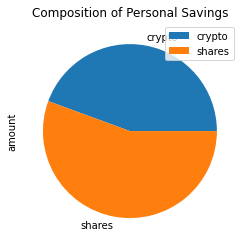

In [27]:
# Plot savings pie chart
my_assets_df.plot.pie(y='amount', title = 'Composition of Personal Savings')

In [28]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
my_savings = int(my_assets_df.sum())

# Validate saving health
if my_savings > emergency_fund:
    print("Congratulations, you have enough money in this fund!")
elif my_savings == emergency_fund:
    print("Your savings equal your emergency fund, congratulations on reaching this goal!")
else:
    print("You are close to reaching your financial goal!")

    # need to add calculation to else statement

Congratulations, you have enough money in this fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [29]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [45]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
agg_mc = df_stock_data[df_stock_data["symbol"]=="AGG"].drop("symbol", axis=1)
spy_mc = df_stock_data[df_stock_data["symbol"]=="SPY"].drop("symbol", axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg_mc, spy_mc], axis=1, keys=["AGG","SPY"])

# Display sample data
df_stock_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-05-02 04:00:00+00:00       15119  110.627199  206.90  208.18  206.41   
2016-05-03 04:00:00+00:00       15662  110.865995  206.50  206.80  205.28   
2016-05-04 04:00:00+00:00       13982  110.879063  205.00  205.85  204.42   
2016-05-05 04:00:00+00:00       15707  111.028363  205.57  205.98  204.47   
2016-05-06 04:00:00+00:00       12697  111.031967  204.04  205.77  203.88   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00  208.03   61908515      263580  207.294812  
2016-05-03 04:00:00+00:00  206.13  106422142      377518  206.312060  
2016-05-04 04:00:00+00:00  204.96   92199810      345261  205.090172  
2016-05-05 04:00:00+00:00  204.95   67597222      280622  205.141555  
2016-05-06 04:00:00+00:00  205.70   89131004      340335  204.937074

In [46]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# Set number of simulations
num_sims = 500

# Configure a Monte Carlo simulation to forecast one year daily returns
mc_30 = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4, 0.6],
    num_simulation = num_sims,
    num_trading_days = 252*30
)

In [47]:
# Printing the simulation input data
mc_30.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.90   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001808  206.50   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  205.00   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.57   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.04   

                                                                          \
                             high     low   close     volume trade_count   
timestamp                                                                  
2016-05-02 04:00:00+00:00  208.18  206.41  208.03   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.13  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  204.96   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.95   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.70   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.009133  
2016-05-04 04:00:00+00:00  205.090172    -0.005676  
2016-05-05 04:00:00+00:00  205.141555    -0.000049  
2016-05-06 04:00:00+00:00  204.937074     0.003659

In [48]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
import warnings
warnings.filterwarnings('ignore')
mc_30.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002796,1.004601,1.003999,0.997164,0.996037,0.993123,1.010910,1.001670,1.005298,0.995789,...,0.993950,0.991071,0.999209,0.994042,0.999157,1.008255,0.996146,0.998617,0.995838,1.003469
2,1.010084,1.012635,1.005583,1.002500,1.002007,0.993267,1.008198,1.000961,1.013704,0.980784,...,0.990886,0.989092,0.998479,0.997191,1.006279,0.994481,1.008386,1.002283,0.986617,1.016616
3,1.011736,1.001384,1.020431,1.005076,1.005805,0.995336,1.025911,0.998452,1.022270,0.976124,...,0.993697,0.986911,0.985839,1.000174,1.018390,0.987134,1.016458,1.008637,1.001517,1.029108
4,1.013673,1.009544,1.031835,1.015879,1.014243,1.000886,1.033641,0.988002,1.040774,0.977999,...,0.989720,0.993723,0.977985,0.989079,1.017024,0.981579,1.022002,1.004590,1.005156,1.032906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,17.443105,35.427803,15.637941,23.597512,13.973986,14.276570,12.720567,11.460103,11.319374,9.995048,...,21.843794,16.469774,25.398100,37.691936,14.495643,20.489320,22.516070,12.543458,7.070845,24.181189
7557,17.270376,35.571198,15.696072,24.011839,14.125008,14.346330,12.601788,11.517866,11.282904,10.059905,...,21.577219,16.416377,25.242571,37.870540,14.445887,20.765949,22.588523,12.489454,6.983226,24.247479
7558,17.266360,35.542019,15.563612,23.806806,14.039906,14.285465,12.564252,11.503199,11.314566,9.992775,...,21.317121,16.610509,25.248444,37.582493,14.464745,20.637710,22.876697,12.543224,7.031282,24.288043
7559,17.534831,35.389083,15.593952,23.884491,14.111580,14.279460,12.517613,11.623428,11.391401,10.015218,...,21.344995,16.537583,25.255175,38.034254,14.658587,20.597434,23.073436,12.509805,6.998483,24.399239


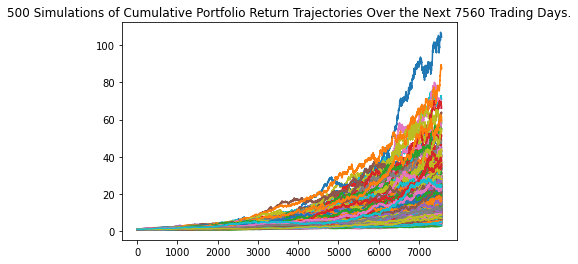

In [49]:
# Plot simulation outcomes
line_plot = mc_30.plot_simulation()

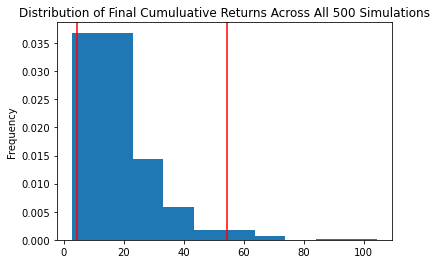

In [50]:
# Plot probability distribution and confidence intervals
dist_plot = mc_30.plot_distribution()

### Retirement Analysis

In [51]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = mc_30.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean             18.406786
std              12.559819
min               2.785152
25%              10.152194
50%              14.684804
75%              23.155724
max             104.198060
95% CI Lower      4.449763
95% CI Upper     54.406918
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [52]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_stats[8]*10000,2)
ci_upper = round(summary_stats[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $44497.63 and $544069.18


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [53]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_stats[8]*15000,2)
ci_upper = round(summary_stats[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $66746.44 and $816103.77


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")